In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("C:/WorkSpace/tcrm")
from Utilities import metutils
sns.set_style('whitegrid')
sns.set_context('talk')

In [7]:
inputPath = "C:/Workspace/data/pi"
inputFile = os.path.join(inputPath, "OTCR.lmi.pi.20210810.csv")
df = pd.read_csv(inputFile)
# Remove any records where the PI is zero - this could filter either observations where LMI 
# is achieved over land, or where the PI data is not available
df =df[df['dailyvmax'] != 0]

In [8]:
# Speed is stored in the file in km/h - conversion to knots
df['speed'] = metutils.convert(df.speed, 'kmh', 'kts')

In [12]:
# Maximum wind speed is stored in the file in m/s - convert to knots
#df['vmax'] = metutils.convert(df.vmax, 'mps', 'kts')

In [9]:
# It's also a 10-minute mean wind speed, so convert to a 1 minute mean for off-sea conditions.
# I use a factor determined using the approach of Harper et al (2010), which gives a
# conversion factor of 1.069. Note Courtney and Knaff (2009) used a factor of 1.13, but point out 
# that other factors are possible. The factor used here corresponds to the value they identify from 
# Harper et al's preliminary work
df['vmax'] = 1.029 * df.vmax

In [10]:
# Convert the PI values from m/s to knots. I assume these are all a 1-minute mean 
# wind speed, since that is the convention used in the Atlantic and Eastern Pacific basins.
df['dailyvmax'] = metutils.convert(df.dailyvmax, 'mps', 'kts')
df['dailyltmvmax'] = metutils.convert(df.dailyltmvmax, 'mps', 'kts')
df['monthlyvmax'] = metutils.convert(df.monthlyvmax, 'mps', 'kts')

Now we remove the forward speed from the observed Vmax. Courtney and Knaff (2009) use $V_{srm} = V_{max} - 1.5C^{0.63}$, C=storm motion in knots, Vmax is 1-min sustained wind speed.

In [11]:
# Now to remove the forward speed from the observed vmax. We use Courtney and Knaff's approach:
df['vsrm'] = df.vmax - 1.5 * np.power(df.speed, 0.63)

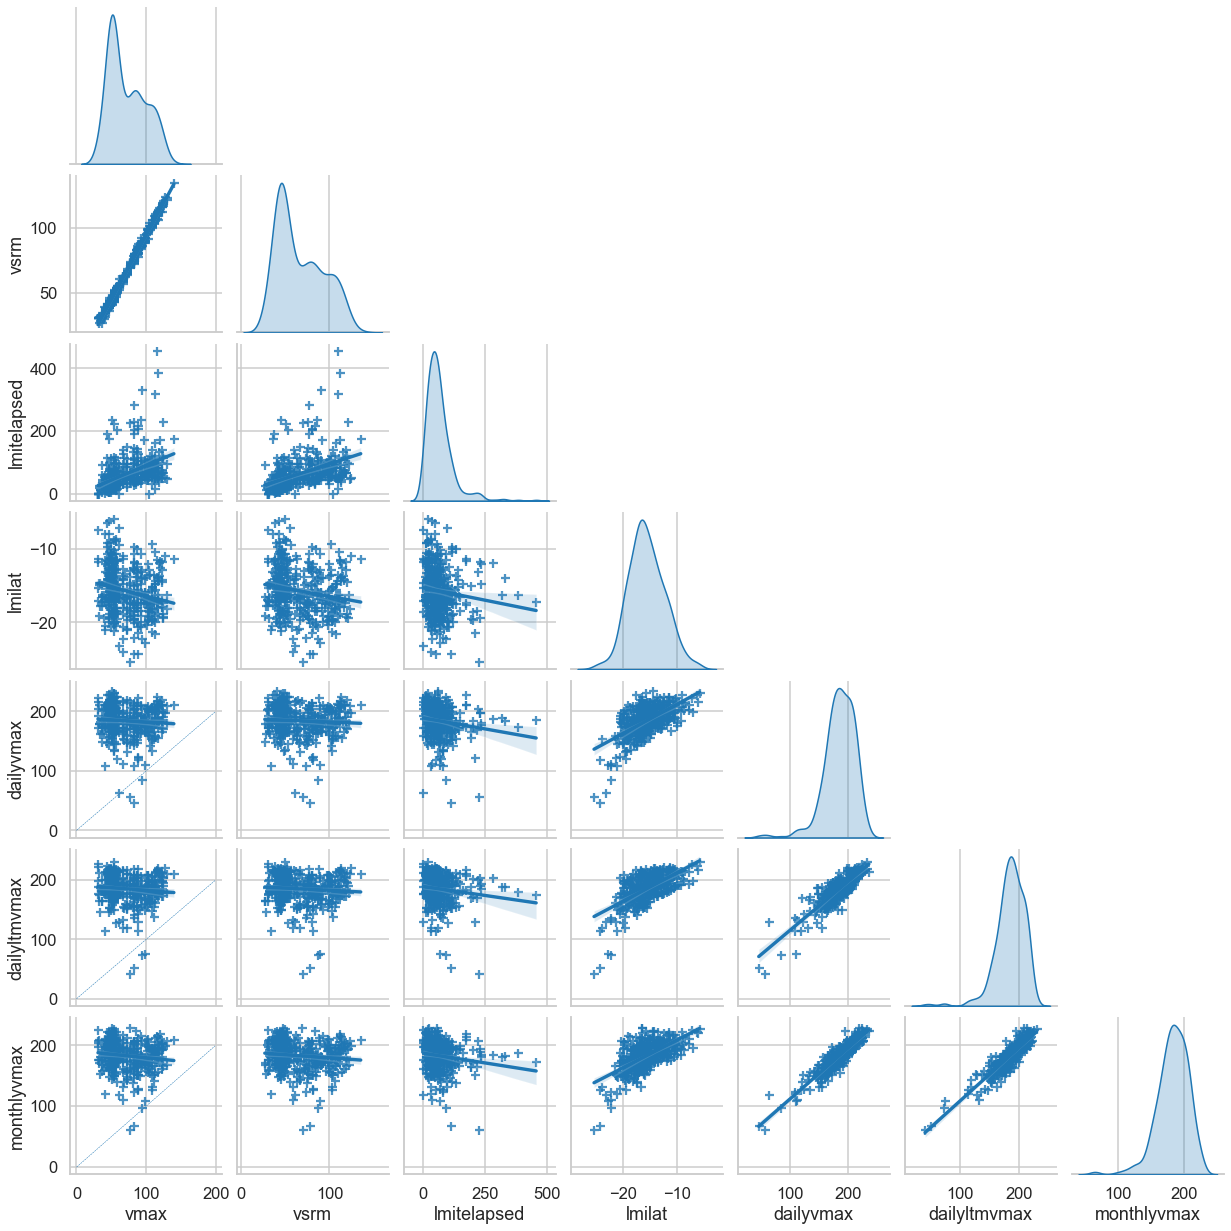

In [12]:
g = sns.pairplot(df, corner=True,
                 vars=['vmax', 'vsrm',
                       'lmitelapsed', 'lmilat', 
                       'dailyvmax', 'dailyltmvmax', 
                       'monthlyvmax'],
                 markers="+",
                 diag_kind="kde",
                 kind='reg')
                 #plot_kws={'alpha':0.5})
g.axes[4][0].plot(np.arange(0, 200), np.arange(0, 200), ls='--', lw=0.5)
g.axes[5][0].plot(np.arange(0, 200), np.arange(0, 200), ls='--', lw=0.5)
g.axes[6][0].plot(np.arange(0, 200), np.arange(0, 200), ls='--', lw=0.5)

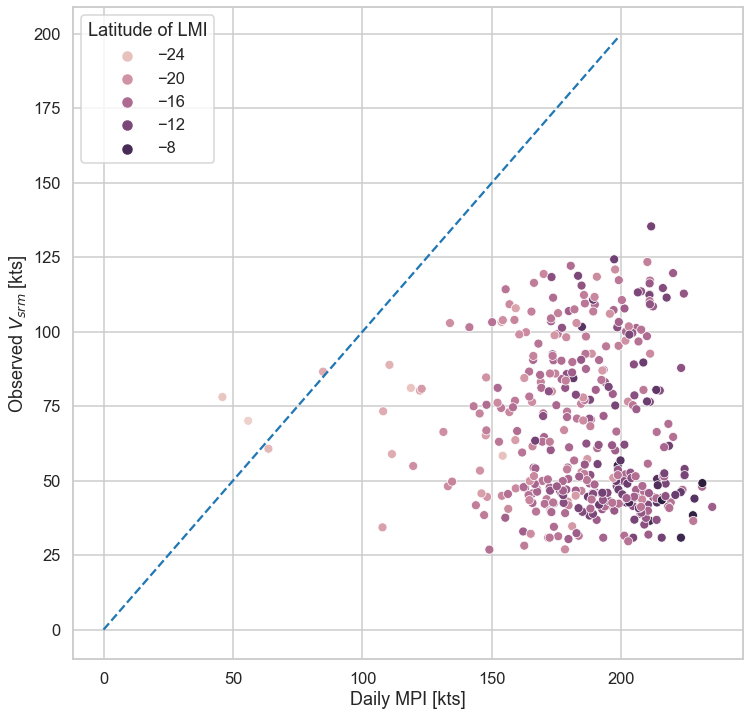

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
sns.scatterplot(x='dailyvmax', y='vsrm', data=df,
                hue='lmilat',
                ax=ax)
ax.plot(np.arange(0, 200), np.arange(0, 200), ls='--')
ax.set_ylabel(r"Observed $V_{srm}$ [kts]")
ax.set_xlabel(r"Daily MPI [kts]")
ax.legend(title="Latitude of LMI")
plt.savefig(os.path.join(inputPath, "Vsrm_vs_MPI.20210810.png"), bbox_inches="tight")

There is only a single event (TC _Sam_ , 1990) where the LMI exceeds the instantaneous PI. This is a case where the storm moves over a region of locally lower PI. The daily long term mean PI is 85 knots, but the instantaneous value is only 25 knots. The observation is close to the strong gradient in PI around 20$^{\circ}$S in the Indian Ocean. There are local fluctuations in the PI along this gradient, so this observation could be expected. Further to that, the climatological PI in mid-January for this area is around 60% of the climatological peak (145 knots), which occurs in late March.

Now examine the distribution of the normalised intensity $\nu_{srm} = V_{srm}/MPI$. This is analagous to the normalised wind speed used in Emanuel (2000). As with Emanuel's findings, there is a case to be made that a piecewise linear function can be fit to the cumulative distribution function. Below, we fit a linear function to all values with $ 0.4 < \nu_{srm} < 0.7$. 

In [15]:
nusrm = np.sort(df.vsrm / df.dailyvmax)
psrm = 1. * np.arange(len(nusrm)) / (len(nusrm) - 1)
idxsrm1 = np.where((nusrm < 0.7) & (nusrm > 0.4))[0]
idxsrm2 = np.where((nusrm >= 0.7))[0]

numax = np.sort(df.vmax / df.dailyvmax)
pmax = 1. * np.arange(len(numax)) / (len(numax) - 1)
idxmax1 = np.where((numax < 0.7) & (numax > 0.4))[0]
idxmax2 = np.where((numax >= 0.7))[0]

In [16]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return b*(a - x)

poptsrm1, pcovsrm1 = curve_fit(func, nusrm[idxsrm1], 1 - psrm[idxsrm1])
poptsrm2, pcovsrm2 = curve_fit(func, nusrm[idxsrm2], 1 - psrm[idxsrm2])

poptmax1, pcovmax1 = curve_fit(func, numax[idxmax1], 1 - pmax[idxmax1])
poptmax2, pcovmax2 = curve_fit(func, numax[idxmax2], 1 - pmax[idxmax2])

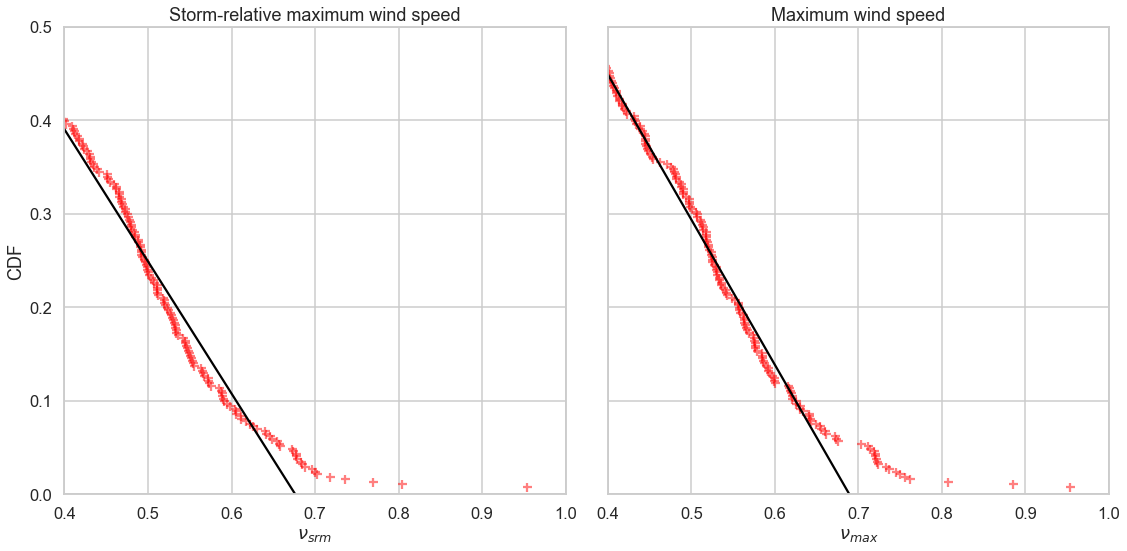

In [17]:
fig, ax = plt.subplots(1,2, figsize=(16, 8), sharey=True)

ax[0].scatter(nusrm, 1-psrm, color='r', marker='+', alpha=0.5)
ax[0].set_xlim((0.4, 1))
ax[0].set_ylim((0, 0.5))
ax[0].set_ylabel("CDF")
ax[0].set_xlabel(r"$\nu_{srm}$")
ax[0].set_title("Storm-relative maximum wind speed")

ax[0].plot(nusrm, func(nusrm, *poptsrm1), 'k')

ax[1].scatter(numax, 1-pmax, color='r', marker='+', alpha=0.5)
ax[1].set_xlim((0.4, 1))
ax[1].set_ylim((0, 0.5))
ax[1].set_xlabel(r"$\nu_{max}$")
ax[1].set_title("Maximum wind speed")

ax[1].plot(numax, func(numax, *poptmax1), 'k')
fig.tight_layout()
None
plt.savefig(os.path.join(inputPath, "Normalised_Intensity_distribution.20210810.png"), bbox_inches="tight")

This result builds confidence that we are evaluating the maximum potential intensity correctly. While the regressions result in different coefficients to the fit, the results are a linear function, mimicking the results from other basins. 

In [17]:
inputFile = os.path.join(inputPath, "TCHA.lmi.pi.csv")
tchadf = pd.read_csv(inputFile)
# Remove any records where the PI is zero - this could filter either observations where LMI 
# is achieved over land, or where the PI data is not available
print(tchadf.columns)
tchadf = tchadf[tchadf['dailyltmvmax'] != 0]

Index(['Unnamed: 0', 'CycloneNumber', 'datetime', 'TimeElapsed', 'lon', 'lat',
       'Speed', 'Bearing', 'CentralPressure', 'EnvPressure', 'rMax',
       'category', 'pdiff', 'ni', 'lmidt', 'startdt', 'lmitelapsed', 'initlat',
       'initlon', 'lmilat', 'lmilon', 'dailyltmvmax', 'dailyltmpmin',
       'monthlyltmvmax', 'monthlyltmpmin', 'monthlyltmaxvmax',
       'monthlyltmaxpmin', 'monthlyvmax', 'monthlypmin'],
      dtype='object')


C:\W10Dev\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


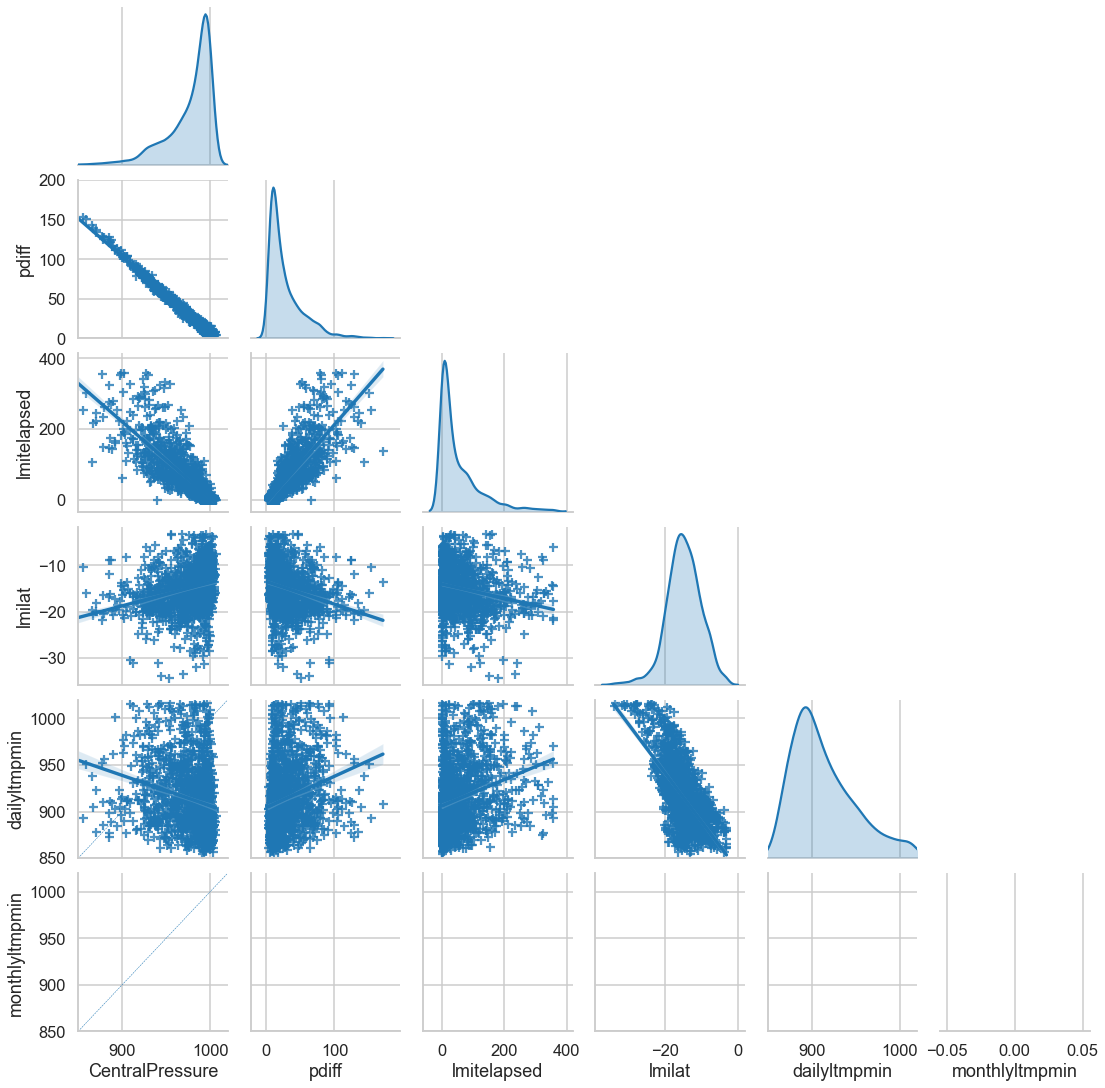

In [27]:
g = sns.pairplot(tchadf, corner=True,
                 vars=['CentralPressure', 'pdiff',
                       'lmitelapsed', 'lmilat',  'dailyltmpmin', 
                       'monthlyltmpmin'],
                 kind="reg",
                 markers="+",
                 diag_kind="kde", )
                 #plot_kws={'alpha':0.5})
g.axes[0][0].set_xlim((850, 1020))
g.axes[1][0].set_ylim((0,200))
#g.axes[3][0].set_ylim((850, 1020))
g.axes[4][0].set_ylim((850, 1020))
g.axes[5][0].set_ylim((850, 1020))
#g.axes[4][3].set_xlim((850, 1020))
g.axes[4][4].set_xlim((850, 1020))
#g.axes[3][0].plot(np.arange(850, 1020), np.arange(850, 1020), ls='--', lw=0.5)
g.axes[4][0].plot(np.arange(850, 1020), np.arange(850, 1020), ls='--', lw=0.5)
g.axes[5][0].plot(np.arange(850, 1020), np.arange(850, 1020), ls='--', lw=0.5)
None